## Nested Logit

In [1]:
import pandas as pd
import pymc as pm
import patsy
import numpy as np
import pytensor.tensor as pt
import arviz as az
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../../..')

%reload_ext autoreload
from pymc_marketing.customer_choice.nested_logit import NestedLogit

In [2]:
df = pd.read_csv('../../../../data/choice_wide_heating.csv')
df

,idcase,depvar,ic_gc,ic_gr,ic_ec,ic_er,ic_hp,oc_gc,oc_gr,oc_ec,oc_er,oc_hp,income,agehed,rooms,region
0,1,gc,866.00,962.64,859.90,995.76,1135.50,199.69,151.72,553.34,505.60,237.88,7,25,6,ncostl
1,2,gc,727.93,758.89,796.82,894.69,968.90,168.66,168.66,520.24,486.49,199.19,5,60,5,scostl
2,3,gc,599.48,783.05,719.86,900.11,1048.30,165.58,137.80,439.06,404.74,171.47,4,65,2,ncostl
3,4,er,835.17,793.06,761.25,831.04,1048.70,180.88,147.14,483.00,425.22,222.95,2,50,4,scostl
4,5,er,755.59,846.29,858.86,985.64,883.05,174.91,138.90,404.41,389.52,178.49,2,25,6,valley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,gc,766.39,877.71,751.59,869.78,942.70,142.61,136.21,474.48,420.65,203.00,6,20,4,mountn
896,897,gc,1128.50,1167.80,1047.60,1292.60,1297.10,207.40,213.77,705.36,551.61,243.76,7,45,7,scostl
897,898,gc,787.10,1055.20,842.79,1041.30,1064.80,175.05,141.63,478.86,448.61,254.51,5,60,7,scostl
898,899,gc,860.56,1081.30,799.76,1123.20,1218.20,211.04,151.31,495.20,401.56,246.48,5,50,6,scostl


In [ ]:
alternatives = ['gc', 'ec', 'gr', 'er', 'hp']

coords = {
    "alts": alternatives,
    "alts_probs": alternatives[:-1],
    "covariates": ['ic', 'oc'],
    "fixed_covariates": ['income'],
    'nests': ['central', 'room'],
    'room_alts': ['gr', 'er', 'hp'],
    'central_alts': ['gc', 'ec'],
    "obs": range(len(df)),
}


# Mode mapping
mode_mapping = {'gc': 0, 'ec': 1, 'gr': 2, 'er': 3, 'hp': 4}
df['mode_encoded'] = df['depvar'].map(mode_mapping)
y = df['mode_encoded'].values

nest_indices = {'central': [0, 1],
               'room': [2, 3, 4], 
               'room_hp': [4],
               'room_r': [2, 3]
               }

lambda_lkup = {'room': 0, 'central': 1}

coords

{'alts': ['gc', 'ec', 'gr', 'er', 'hp'],
 'alts_probs': ['gc', 'ec', 'gr', 'er'],
 'covariates': ['ic', 'oc'],
 'fixed_covariates': ['income'],
 'nests': ['central', 'room'],
 'room_alts': ['gr', 'er', 'hp'],
 'central_alts': ['gc', 'ec'],
 'obs': range(0, 900)}

In [182]:
utility_formulas = ['gc ~ ic_gc + oc_gc | income ', 
                    'ec ~ ic_ec + oc_ec | income ',
                    'gr ~ ic_gr + oc_gr | income ', 
                    'er ~ ic_er + oc_er | income ', 
                    'hp ~ ic_hp + oc_hp | income ']

nstL = NestedLogit(df, utility_formulas, 'depvar', covariates=['ic', 'oc'], nesting_structure=nest_indices)
nstL

In [183]:
X, F, y = nstL.preprocess_model_data(df, utility_formulas)
print(X.shape)
F.shape

(900, 5, 2)


In [184]:
N = df.shape[0]

def make_exp_nest(U, w_nest, lambdas_nests, nest, parent_lambda=None):
    y_nest = U[:, nest_indices[nest]]
    if len(nest_indices[nest]) > 1:
        max_y_nest = pm.math.max(y_nest, axis=0)
        P_y_given_nest = pm.Deterministic(
            f"p_y_given_{nest}",
            pm.math.softmax(y_nest / lambdas_nests[lambda_lkup[nest]], axis=1),
            dims=("obs", f"{nest}_alts"),
        )
    else:
        max_y_nest = pm.math.max(y_nest)
        ones = pm.math.ones((N, 1))
        P_y_given_nest = pm.Deterministic(f"p_y_given_{nest}", ones)
    if parent_lambda is None:
        lambda_ = lambdas_nests[lambda_lkup[nest]]
        I_nest = pm.Deterministic(
            f"I_{nest}", pm.math.logsumexp((y_nest - max_y_nest) / lambda_)
        )
        W_nest = w_nest + I_nest * lambda_
    else:
        l1 = lambdas_nests[lambda_lkup[nest]]
        l2 = lambdas_nests[lambda_lkup[parent_lambda]]
        lambdas_ = l1 * l2
        I_nest = pm.Deterministic(
            f"I_{nest}", pm.math.logsumexp((y_nest - max_y_nest) / lambdas_)
        )
        W_nest = w_nest + I_nest * (lambdas_)

    exp_W_nest = pm.math.exp(W_nest)
    return exp_W_nest, P_y_given_nest

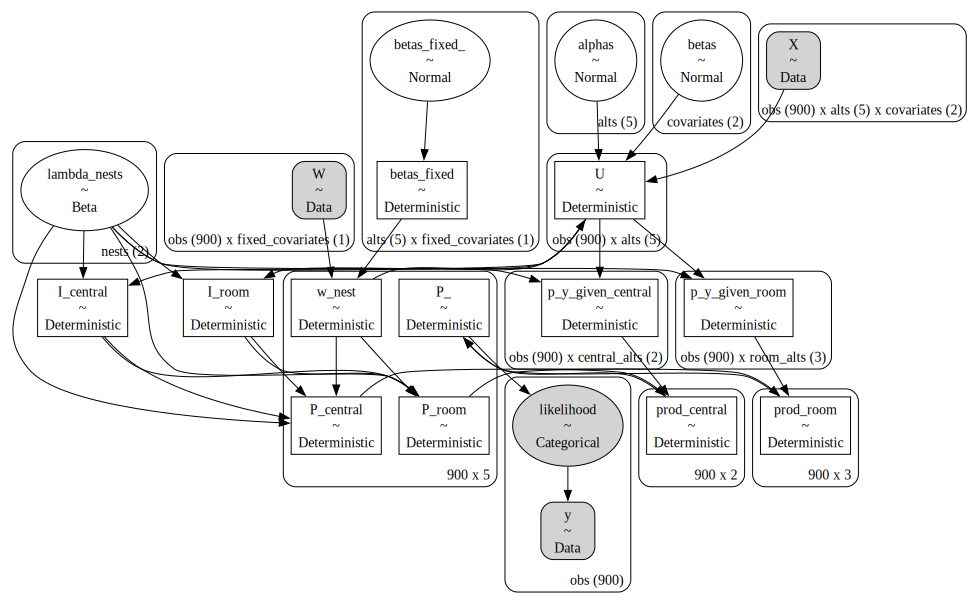

In [ ]:
def make_model(X, y, W, N=900):
    with pm.Model(coords=coords) as model:
        alphas = pm.Normal('alphas', 0, 5, dims='alts')
        betas = pm.Normal('betas', 0, 1, dims=('covariates'))
        lambdas_nests = pm.Beta('lambda_nests', 2, 2, dims='nests')
        
        if W is None:
            w_nest = pm.math.zeros((N, 5))
        else: 
            W_data = pm.Data('W', W, dims=('obs', 'fixed_covariates'))
            betas_fixed_ = pm.Normal('betas_fixed_', 0, 1, dims=('alts', 'fixed_covariates'))
            betas_fixed = pm.Deterministic('betas_fixed', pt.set_subtensor(betas_fixed_[-1, :], 0), 
                dims=('alts','fixed_covariates'))
            w_nest = pm.Deterministic('w_nest', pm.math.dot(W_data, betas_fixed.T))
        X_data = pm.Data('X', X,  dims=('obs', 'alts', 'covariates'))
        y_data = pm.Data('y', y, dims='obs')

        # Compute utility as a dot product
        alphas = pt.set_subtensor(alphas[-1], 0)
        u = alphas + pm.math.dot(X_data, betas)
        U = pm.Deterministic('U', w_nest + u, dims=('obs', 'alts'))
        
        ## Top Level
        conditional_probs = {}
        for n in nest_indices.keys():
            exp_W_nest, P_y_given_nest = make_exp_nest(U, w_nest, 
                lambdas_nests, n)
            conditional_probs[n] = {'exp': exp_W_nest, 'P_y_given': P_y_given_nest}
      
        denom = pm.math.sum([conditional_probs[n]['exp'] for n in nest_indices.keys()])
        nest_probs = {}
        for n in nest_indices.keys():
            P_nest = pm.Deterministic(f'P_{n}', (conditional_probs[n]['exp'] / denom))
            nest_probs[n] = P_nest
        
        ## Construct Paths Bottom -> Up
        path_prods = []
        for n in nest_indices.keys():
            P_nest = nest_probs[n]
            P_y_given_nest = conditional_probs[n]['P_y_given']
            prod = pm.Deterministic(f'prod_{n}', (P_nest[:, nest_indices[n]]*P_y_given_nest))
            path_prods.append(prod)
        P_ = pm.Deterministic('P_',  pm.math.concatenate(path_prods, axis=1))

        ## Probability Matrix
        choice_obs = pm.Categorical("likelihood", p=P_, observed=y_data, dims="obs")

    return model


model = make_model(X, y, W=F)
pm.model_to_graphviz(model)

In [192]:
with model: 
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(
        target_accept=.97,
        nuts_sampler='numpyro',
        idata_kwargs={"log_likelihood": True}, 
        random_seed=101))
    

Sampling: [alphas, betas, betas_fixed_, lambda_nests, likelihood]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [193]:
az.summary(idata, var_names=['alphas', 'betas', 'betas_fixed'])

#az.summary(idata, var_names=['alphas', 'betas'])

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alphas[gc],-0.850,3.562,-7.665,5.733,0.072,0.061,2434.0,2356.0,1.0
alphas[ec],0.863,3.576,-5.606,7.871,0.072,0.061,2442.0,2489.0,1.0
alphas[gr],0.134,0.200,-0.234,0.506,0.003,0.003,3446.0,3092.0,1.0
alphas[er],2.089,0.351,1.420,2.716,0.007,0.005,2834.0,2734.0,1.0
alphas[hp],0.085,5.056,-9.350,9.650,0.082,0.088,3845.0,2148.0,1.0
betas[ic],-0.002,0.001,-0.003,-0.000,0.000,0.000,4915.0,3283.0,1.0
betas[oc],-0.007,0.001,-0.010,-0.004,0.000,0.000,3023.0,2798.0,1.0
"betas_fixed[gc, income]",0.273,0.014,0.246,0.300,0.000,0.000,2912.0,3109.0,1.0
"betas_fixed[ec, income]",-0.089,0.027,-0.138,-0.039,0.000,0.000,3737.0,2799.0,1.0
"betas_fixed[gr, income]",-0.016,0.022,-0.059,0.024,0.000,0.000,2985.0,2901.0,1.0


In [126]:
def make_nested_logit(X, y, coords, nest_indices, N, X_fixed=None):

    with pm.Model(coords=coords) as nested_model:
        alphas = pm.Normal('alphas', 0, 5, dims='alts')
        betas = pm.Normal('betas', 0, 1, dims=('covariates'))
        lambdas_nests = pm.Beta('lambda_nests', 2, 2, dims='nests')

        ## Nest Fixed values like income
        if X_fixed is None: 
            W = pm.math.zeros(N)
        else: 
            betas_fixed = pm.Normal('beta_fixed', 0, 1, 
                dims=('fixed_covariates', 'alts'))
            X_fixed = pm.MutableData('X_fixed', X_fixed, 
                dims=('obs', 'fixed_covariates'))
            W = pm.Deterministic('W', pm.math.dot(X_fixed, betas_fixed))

        X = pm.MutableData('X', X, dims=('obs', 'alts', 'covariates'))
        y = pm.MutableData('y', y, dims='obs')

        alphas = pt.set_subtensor(alphas[-1], 0)
        U = pm.Deterministic('U', 
            (alphas + pm.math.dot(X, betas)), 
            dims=('obs', 'alts'))

        #U = W[:, pt.newaxis] + U

        
        ## Create Nest Specific Probabilities
        nest_probabilities = []
        mprob_nest = {}
        for i, n in enumerate(nest_indices.keys()) :
            u = U[:, nest_indices[f'{n}']]
            y_nest = pm.Deterministic(f'y_{n}', u, 
                dims=('obs', f'{n}_alts'))
            if len(nest_indices[f'{n}']) > 1:
                max_y_nest = pm.math.max(y_nest, axis=0)
                s = pm.math.softmax(y_nest / lambdas_nests[i], axis=1)
                P_y_given_nest = pm.Deterministic(f'p_y_given_{n}', s, 
                    dims = ('obs', f'{n}_alts')) 
            else: 
                max_y_nest = pm.math.max(y_nest)
                ones = pm.math.ones((N, 1))
                P_y_given_nest = pm.Deterministic(f'p_y_given_{n}', ones)
            lsexp = pm.math.logsumexp((y_nest - max_y_nest)/lambdas_nests[i])
            I_nest = pm.Deterministic(f'I_{n}', lsexp)

            W_nest = W + I_nest*lambdas_nests[i]
            exp_W_nest = pm.math.exp(W_nest)
            nest_probabilities.append(exp_W_nest)
            mprob_nest[n] = P_y_given_nest

        ## Define Conditional Probability
        final_stack = []
        for n, np in zip(nest_indices.keys(), nest_probabilities): 
            P_nest =  pm.Deterministic(f'P_{n}', 
                (np / pm.math.sum(nest_probabilities, axis=0)), 
                dims='obs')
            prod = (mprob_nest[n]*P_nest[:, pt.newaxis])
            P_y_nest = pm.Deterministic(f'P_y_{n}', prod)
            final_stack.append(P_y_nest)

        # Stack into probability matrix
        final_stack = pm.math.concatenate(final_stack, axis=1)
        p_ = pm.Deterministic('p', final_stack, dims=('obs', 'alts'))
        
        choice_obs = pm.Categorical("y_cat", p=p_, observed=y, dims="obs")

    return nested_model

nested_model = make_nested_logit(X, y, coords, nest_indices, N, F)

pm.model_to_graphviz(nested_model)



/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


ValueError: P_central has 2 dims but 1 dim labels were provided.

In [120]:
with nested_model: 
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(
        target_accept=.97,
        idata_kwargs={"log_likelihood": True}, 
        random_seed=101))

Sampling: [alphas, betas, lambda_nests, y_cat]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alphas, betas, lambda_nests]
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 205 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [121]:
az.summary(idata, var_names=['alphas', 'betas'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alphas[gc],-0.032,3.614,-6.777,6.552,0.079,0.063,2092.0,1884.0,1.0
alphas[ec],0.063,3.621,-6.361,6.984,0.080,0.063,2044.0,1922.0,1.0
alphas[gr],0.079,0.149,-0.189,0.374,0.003,0.003,2280.0,2187.0,1.0
alphas[er],1.477,0.379,0.808,2.227,0.011,0.006,1185.0,1524.0,1.0
alphas[hp],-0.056,4.936,-9.726,8.845,0.078,0.089,4012.0,2517.0,1.0
betas[ic],-0.001,0.001,-0.002,-0.000,0.000,0.000,2488.0,2481.0,1.0
betas[oc],-0.006,0.002,-0.009,-0.003,0.000,0.000,1132.0,1354.0,1.0
